In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import math
import statistics
from collections import namedtuple, deque, Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda")

# Define the Actor and Critic

Actor - proposes an action given a state $u(s|theta^u)\rightarrow a$

Critic - predicts the actions quality given the state and action $Q(s,a)$

NoiseClass - generates the noise, we will be using an Ornstein-Uhlenbeck Process 

Will start by doing the pendulum problem

In [3]:
class OUNoise:
    # https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
    def __init__(self, mean, stdev, theta=0.15, dt = 1e-2, x_init=None):
        self.theta = theta
        self.mean = mean
        self.stdev = stdev
        self.dt = dt 
        self.x_init = x_init
        
    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + \
            self.stdev * np.sqrt(self.dt) * np.random.normal(size = self.mean.shape)
        
        self.x_prev = x
        return x
    
    def reset(self):
        if self.x_init is not None:
            self.x_prev = self.x_init
        else:
            self.x_prev = np.zeros_like(self.mean)
            

In [4]:
class MemoryReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = deque(maxlen=capacity)
        
    def __len__(self):
        return len(self.data)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.data.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(next_states), np.stack(dones)

    

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.max_action * torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], 1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class DDPG:
    def __init__(self, state_dim, action_dim, max_action_val, gamma=0.99, noise_var=0.2, tau=0.001) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3, amsgrad=True)

        self.critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-3, amsgrad=True)
        
        self.gamma = gamma
        self.tau = tau
        self.max_action_val = max_action_val
        self.memory = MemoryReplay(100000)
        self.ou_noise = OUNoise(np.zeros(1), np.ones(1)*noise_var)
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def select_action(self, state, add_noise=True, noise_factor=1):
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        samp_action = self.actor(state).cpu().data.numpy().flatten()
        samp_action += np.random.normal(0, self.max_action_val*.1, size=self.action_dim) * noise_factor
        # if add_noise:
        #     noise = self.ou_noise()
        #     samp_action = samp_action + noise*noise_factor
        return samp_action.clip(-self.max_action_val, self.max_action_val)
    
    def step(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        
        state, action, reward, next_state, done = self.memory.sample(batch_size)
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        action = torch.tensor(action, dtype=torch.float32, device=self.device)
        reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
        done = torch.tensor(done, dtype=torch.float32, device=self.device)
        
        next_action = self.target_actor(next_state)
        target_Q = self.target_critic(next_state, next_action)
        target_Q = reward+((1-done)*self.gamma*target_Q).detach()
        
        # Update the critic
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update the actor
        actor_loss = -1*self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Soft update the weights
        tc_sd = self.target_critic.state_dict()
        c_sd = self.critic.state_dict()
        for kkey in tc_sd:
            tc_sd[kkey] = c_sd[kkey]*self.tau+tc_sd[kkey]*(1-self.tau)
        self.target_critic.load_state_dict(tc_sd)
            
        ta_sd = self.target_actor.state_dict()
        a_sd = self.actor.state_dict()
        for kkey in ta_sd:
            ta_sd[kkey] = a_sd[kkey]*self.tau+ta_sd[kkey]*(1-self.tau)
        self.target_actor.load_state_dict(ta_sd)
        
        
        
        
        

In [8]:
import gymnasium as gym

env = gym.make("Pendulum-v1")

NUM_STATES = env.observation_space.shape[0]
print("Size of State Space: {}".format(NUM_STATES))
NUM_ACTIONS = env.action_space.shape[0]
print("Size of Action Space: {}".format(NUM_ACTIONS))

UPPER_BOUND = env.action_space.high[0]
LOWER_BOUND = env.action_space.low[0]

print("Max Value of Action: {}".format(UPPER_BOUND))
print("Min Value of Action: {}".format(LOWER_BOUND))

Size of State Space: 3
Size of Action Space: 1
Max Value of Action: 2.0
Min Value of Action: -2.0


In [71]:
training_env = DDPG(NUM_STATES, NUM_ACTIONS, UPPER_BOUND)

n_eps = 100
n_steps = 1000

acc_rewards = []

for episode in range(n_eps):
    state = env.reset()[0]
    
    acc_reward = 0
    training_env.ou_noise.reset()
    
    for step in range(n_steps):
        action = training_env.select_action(state, noise_factor=episode/n_eps)
        
        next_state, reward, done, _, _ = env.step(action)
        
        training_env.memory.push(state, action, reward, next_state, done)
        training_env.step()
        
        state = next_state
        acc_reward+=reward
        
        if done:
            print("Done Reached")
            break
        
    print(f"{episode}/{n_eps} -- reward = {acc_reward}")
    acc_rewards.append(acc_reward)
    

/home/danny/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/100 -- reward = -7578.054154876232
1/100 -- reward = -7486.455048697697
2/100 -- reward = -7478.136386534093
3/100 -- reward = -7535.0969291745105
4/100 -- reward = -7534.4057148719585
5/100 -- reward = -7520.07577625386
6/100 -- reward = -7430.369337912506
7/100 -- reward = -7192.315343248922
8/100 -- reward = -5126.616138417103
9/100 -- reward = -4062.4014515121494
10/100 -- reward = -7511.953415076618
11/100 -- reward = -3820.2222999514534
12/100 -- reward = -1927.9117200898472
13/100 -- reward = -1786.3978071054364
14/100 -- reward = -1015.9188162891934
15/100 -- reward = -130.75518657390998
16/100 -- reward = -265.08569925808115
17/100 -- reward = -319.9286210152586
18/100 -- reward = -118.96319003665624
19/100 -- reward = -265.9377799381149
20/100 -- reward = -268.03784336732014
21/100 -- reward = -137.61007472544264
22/100 -- reward = -270.29941683218505
23/100 -- reward = -144.7813776389747
24/100 -- reward = -34.63947922291931
25/100 -- reward = -258.74925253890723
26/100 --

# Now Experiment With Stocks

In [7]:
top_8_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSM']
top_4_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

used_tech = top_8_tech

In [13]:
# run this to download the data 
datas = {}
num_shares = {}
for ticker in used_tech:
    data = yf.Ticker(ticker)
    df = data.history(period="2y", interval='1h')
    datas[ticker] = df
    df.to_csv(f"data/stocksv2/{ticker}.csv")
    
    num_shares[ticker] = int(data.info['marketCap']/data.info['previousClose'])

In [8]:
# run this to load the data wo re-downloading
datas = {}
num_shares = {}

for ticker in used_tech:
    datas[ticker] = pd.read_csv(f"data/stocksv1/{ticker}.csv").set_index('Date')
    data = yf.Ticker(ticker)
    
    # Note: This will break if there are any stock splits between the last time the data was downloaded
    # and the time the num shares is computed. Redownload data if this happens
    num_shares[ticker] = int(data.info['marketCap']/data.info['previousClose'])

In [9]:
for ticker in num_shares.keys():
    print(f"Market cap {ticker} = {num_shares[ticker]*datas[ticker].iloc[-1]['Close']}")

Market cap AAPL = 2680686991484.9976
Market cap MSFT = 2265602168568.0
Market cap GOOG = 1361243510800.6487
Market cap AMZN = 1092789025892.7257
Market cap NVDA = 667560313668.4628
Market cap META = 534840462723.4628
Market cap TSLA = 520912490392.5
Market cap TSM = 434613385816.75


([<matplotlib.axis.XTick at 0x7f7b5512fac0>,
 [Text(0, 0, '2018-04-27 00:00:00-04:00'),
  Text(1258, 0, '2023-04-26 00:00:00-04:00')])

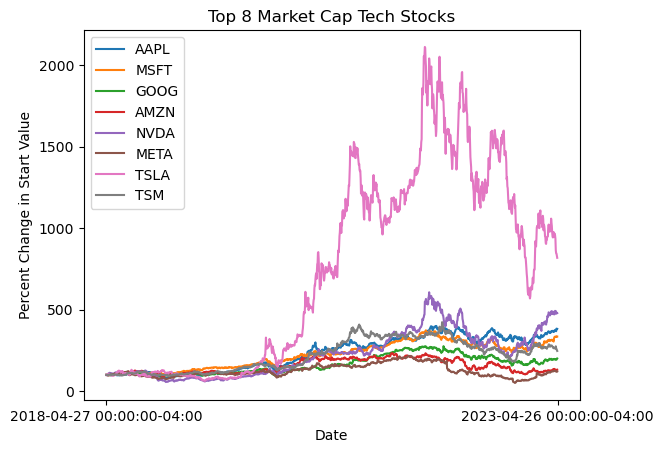

In [10]:
for ticker in used_tech:
    stval = datas[ticker]['High'][0]
    datas[ticker]['High'].apply(lambda x: 100*x/stval).plot()
plt.legend(top_8_tech)
plt.ylabel("Percent Change in Start Value")
plt.title("Top 8 Market Cap Tech Stocks")
plt.xticks([0, len(datas[ticker]-1)], [datas[ticker].index[0], datas[ticker].index[-1]], rotation=0)

# Stock market simulation

Although all we have is historical data for stocks. We can think about simulating the stock market in real time with this data. This relies on the assumption that we are making small volume trades that dont affect the stock market at all. 

### Problem Setup

We have downloaded 5 years of daily stock data for the top 8 market cap tech stocks. We are going to see if we can devise a trading strategy using deep q learning to trade between these stocks every day. Our actions will be taken every day at open, where we will be able to buy any distribution of the top 8 market cap tech stocks that we want. We will then sell all at the close. Devising a trading strategy that holds overnight will be an exercise for the future. 


In [62]:
class StockGameSimulator:
    def __init__(self, datas, eval_hold = 0.33, included_lag = 0) -> None:
        self.datas = datas
        self.eval_hold = eval_hold
        self.included_lag = included_lag
        self.preprocess_datas()
        
    def preprocess_datas(self):
        # First put all of the needed data in one dataframe
        foo = []
        for ticker in used_tech:
            foo.append(datas[ticker].rename(
                columns={'Open': f"{ticker} Open", 'Close': f"{ticker} Close"}).drop(
                    columns=['High', 'Low', 'Volume', 'Dividends', 'Stock Splits']
                    )
                )
        df = pd.concat(foo, axis='columns')
        df.to_csv("data/stocksv1/combined.csv")

        log_df = df.copy(deep=True)
        
        # preprocess data to make values the total company value at that time
        for coll in df.columns:
            df[coll] = df[coll].apply(lambda x: x*num_shares[coll.split(' ')[0]])
            
        open_sum = df[[f"{xx} Open" for xx in used_tech]].sum(axis=1)
        close_sum = df[[f"{xx} Close" for xx in used_tech]].sum(axis=1)

        for coll in df.columns:
            if 'Open' in coll:
                df[coll] = df[coll]/open_sum
            else:
                df[coll] = df[coll]/close_sum
                
        opens = df[[f"{xx} Open" for xx in used_tech]].sum(axis=1)
        print(f"Check about equal to one {max(opens)} and {min(opens)}")

        closes = df[[f"{xx} Close" for xx in used_tech]].sum(axis=1)
        print(f"Check about equal to one {max(closes)} and {min(closes)}")

        self.X = df[[cc for cc in df.columns if 'Open' in cc]]
        self.stock_keys = self.X.columns
        
        X_proc = []
        for ii in range(len(self.X)):
            if ii < self.included_lag:
                X_proc.append(np.zeros(len(self.stock_keys)*(1+self.included_lag)))
            else:
                curcol = np.array(self.X.iloc[ii])
                for jj in range(self.included_lag):
                    curcol = np.append(curcol, np.array(self.X.iloc[ii - (jj+1)]))
                X_proc.append(curcol)
        self.X_proc = np.array(X_proc)
                    
        # generate the rewards matrix
        for ticker in used_tech:
            log_df[f"{ticker} Delta"] = log_df[f"{ticker} Close"]/log_df[f"{ticker} Open"] - 1
        self.rewards = log_df[[cc for cc in log_df.columns if 'Delta' in cc]]
        
        self.log_df = log_df
        self.current_index = self.included_lag

        self.eval_cutoff = int(self.eval_hold*len(self.X))
    
    def _get_state(self):
        return self.X_proc[self.current_index]
    
    def _get_reward(self, action):
        norm_action = action/np.sum(np.abs(action))
        return np.dot(norm_action, self.rewards.iloc[self.current_index])
    
    def reset(self):
        self.current_index = self.included_lag
        return self._get_state()
        
    def step(self, action):
        self.current_index += 1
        done = 0 if self.current_index<self.eval_cutoff else 1
        return self._get_state(), self._get_reward(action), done
    
    def eval_reset(self):
        self.current_index = self.eval_cutoff + self.included_lag
        return self._get_state()

    def eval_step(self, action):
        self.current_index += 1
        done = 0 if self.current_index<len(self.X)-1 else 1
        return self._get_state(), self._get_reward(action), self._get_reward(np.array([.25]*len(action))), done

In [63]:
sgs = StockGameSimulator(datas)

Check about equal to one 1.0000000000000002 and 0.9999999999999998
Check about equal to one 1.0000000000000002 and 0.9999999999999998


In [81]:
training_env = DDPG(4, 4, 1)

n_eps = 100
n_steps = 100000

acc_rewards = []

for episode in range(n_eps):
    state = sgs.reset()
    
    acc_reward = 0
    training_env.ou_noise.reset()
    
    for step in range(n_steps):
        action = training_env.select_action(state, noise_factor=episode/n_eps)
        
        next_state, reward, done = sgs.step(action)
        
        training_env.memory.push(state, action, reward, next_state, done)
        training_env.step()
        
        state = next_state
        acc_reward+=reward
        
        if done:
            print("Done Reached")
            break
        
    print(f"{episode}/{n_eps} -- reward = {acc_reward}")
    acc_rewards.append(acc_reward)

/home/danny/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Done Reached
0/100 -- reward = -0.029811460581566154
Done Reached
1/100 -- reward = -0.1520209886228825
Done Reached
2/100 -- reward = -0.0988435846072149
Done Reached
3/100 -- reward = -0.1211822228957863
Done Reached
4/100 -- reward = -0.0527996583603863
Done Reached
5/100 -- reward = -0.05788973453941495
Done Reached
6/100 -- reward = -0.05714613128019746
Done Reached
7/100 -- reward = -0.10173760762643708
Done Reached
8/100 -- reward = -0.12548467376264974
Done Reached
9/100 -- reward = -0.11875753349856487
Done Reached
10/100 -- reward = -0.11766231274777939
Done Reached
11/100 -- reward = -0.08444768475607292
Done Reached
12/100 -- reward = 0.06318526803552044
Done Reached
13/100 -- reward = 0.0839686632549301
Done Reached
14/100 -- reward = 0.10997181760311071
Done Reached
15/100 -- reward = 0.12106187432773088
Done Reached
16/100 -- reward = 0.12229241221179996
Done Reached
17/100 -- reward = 0.12267316295949564
Done Reached
18/100 -- reward = 0.12194711556772621
Done Reached
1

In [64]:
acc_rewards = []

state = sgs.eval_reset()

acc_reward = 0
rewards = []
def_rewards = []
actions = []

training_env.ou_noise.reset()

done = False

while not done:
    action = training_env.select_action(state, noise_factor=0)
    actions.append(action)
    
    next_state, reward, def_reward, done = sgs.eval_step(action)
    print(f"{reward}, {def_reward} -- {reward>def_reward}")
    state = next_state
    acc_reward+=reward
    rewards.append(reward)
    def_rewards.append(def_reward)
    
    if done:
        break
    
print(f"ACC Reward = {acc_reward}")
print(f"Def Reward = {np.sum(def_rewards)}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8 and 88x400)

In [90]:
actions[0:10]

[array([0.99999994, 0.9999959 , 0.99994946, 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.9999497 , 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.99995   , 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.99995005, 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.9999498 , 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.9999497 , 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.99994975, 1.        ], dtype=float32),
 array([0.99999994, 0.9999959 , 0.9999495 , 1.        ], dtype=float32),
 array([0.99999994, 0.9999959 , 0.9999497 , 1.        ], dtype=float32),
 array([0.99999994, 0.99999595, 0.99994975, 1.        ], dtype=float32)]

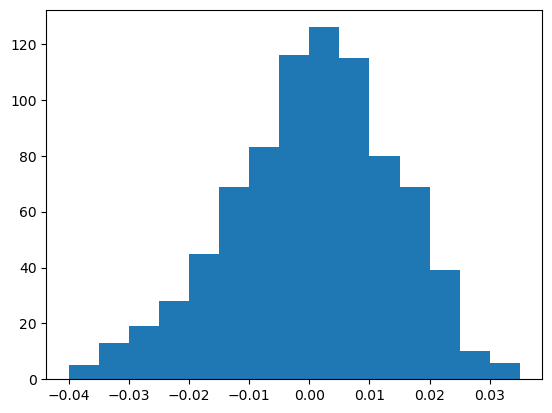

0.0006755203302898163
0.0012642392046294292


In [87]:
plt.figure()
plt.hist(rewards, bins=np.arange(-.04, .04, .005))
plt.show()
print(np.mean(rewards))
print(np.median(rewards))

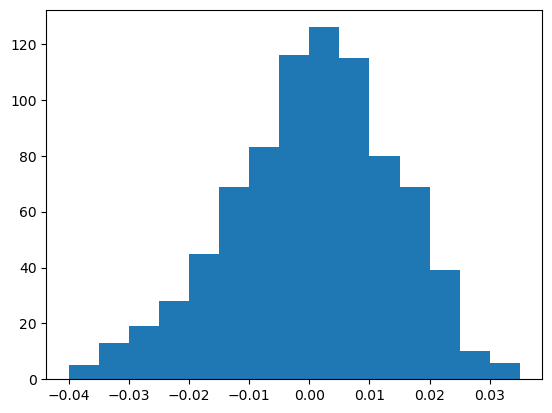

0.0006755248931258398
0.0012641815508576404


In [88]:
plt.figure()
plt.hist(def_rewards, bins=np.arange(-.04, .04, .005))
plt.show()
print(np.mean(def_rewards))
print(np.median(def_rewards))

### Thoughts 

As we see, this model colapses to buying equal of each stock. This may mean that our "iid" assumption about the data (i.e. you only need info about the opening ratios to predict daily performance may be false). Other hypothesis like momentum or mean reversion say that you need info about the past to predict the future. As a result we will no try passing in info about the future. Note: modifications to the stock simulator are being implemented above.

In [59]:
lag_days_to_include = 10
sgs = StockGameSimulator(datas, included_lag=lag_days_to_include)

Check about equal to one 1.0000000000000002 and 0.9999999999999998
Check about equal to one 1.0000000000000002 and 0.9999999999999998


In [61]:
training_env = DDPG(8*(lag_days_to_include+1), 8, 1)

n_eps = 100
n_steps = 100000

acc_rewards = []

for episode in range(n_eps):
    state = sgs.reset()
    
    acc_reward = 0
    training_env.ou_noise.reset()
    
    for step in range(n_steps):
        action = training_env.select_action(state, noise_factor=episode/n_eps)
        
        next_state, reward, done = sgs.step(action)
        
        training_env.memory.push(state, action, reward, next_state, done)
        training_env.step()
        
        state = next_state
        acc_reward+=reward
        
        if done:
            break
    if episode % 10 == 0: 
        print(f"{episode}/{n_eps} -- reward = {acc_reward}")
    acc_rewards.append(acc_reward)
    


/home/danny/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/100 -- reward = 0.04886932679282989
10/100 -- reward = 0.16094155487103584
20/100 -- reward = 0.007430237945060919
30/100 -- reward = 0.1278078539922289
40/100 -- reward = 0.13793326568253592
50/100 -- reward = 0.12354731977497624
60/100 -- reward = 0.16017905874086982
70/100 -- reward = 0.1382770091540036
80/100 -- reward = 0.1468969362261392
90/100 -- reward = 0.1289502674809453


In [50]:
# Evaluation
acc_rewards = []

state = sgs.eval_reset()

acc_reward = 0
rewards = []
def_rewards = []
actions = []

training_env.ou_noise.reset()

done = False

while not done:
    action = training_env.select_action(state, noise_factor=0)
    actions.append(action)
    
    next_state, reward, def_reward, done = sgs.eval_step(action)
    print(f"{reward}, {def_reward} -- {reward>def_reward}")
    state = next_state
    acc_reward+=reward
    rewards.append(reward)
    def_rewards.append(def_reward)
    
    if done:
        break
    
print(f"ACC Reward = {acc_reward}")
print(f"Def Reward = {np.sum(def_rewards)}")


-0.00527035083301533, 0.003753091482871812 -- False
-0.0012447571372011246, -0.005213980820455266 -- True
0.0020641043207700605, 0.0015907152331554875 -- True
0.0032280951645627387, -0.013629680713861447 -- True
-0.0007941743455095462, 0.00251028736612402 -- False
0.003247003533618009, 0.010023240824224622 -- False
0.0010469665602547695, -0.0006207122037663049 -- True
-0.0036901641724184364, 0.005236113493893385 -- False
-0.000660065319058406, -0.022880777089487075 -- True
0.006078269555082921, 0.012674111416151629 -- False
0.006290925294736377, 0.007734025458316723 -- False
-0.0010240636119776547, -0.01339609454502233 -- True
0.0001281075655099051, 0.011313297264260835 -- False
-0.006990805689190305, 0.006205283970049158 -- False
0.0011472223010932647, 0.024526576123607258 -- False
-0.010714687368171383, -0.011736729902924625 -- True
0.0030283134271397727, 0.003539898870603464 -- False
0.0004903003626621216, 0.0022790286675232196 -- False
0.0045921544299864225, 0.001461108872877953 --

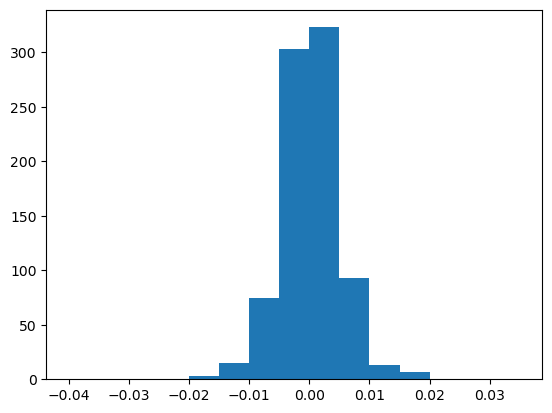

0.0002360949645632092
0.00019200467792784837


In [51]:
plt.figure()
plt.hist(rewards, bins=np.arange(-.04, .04, .005))
plt.show()
print(np.mean(rewards))
print(np.median(rewards))

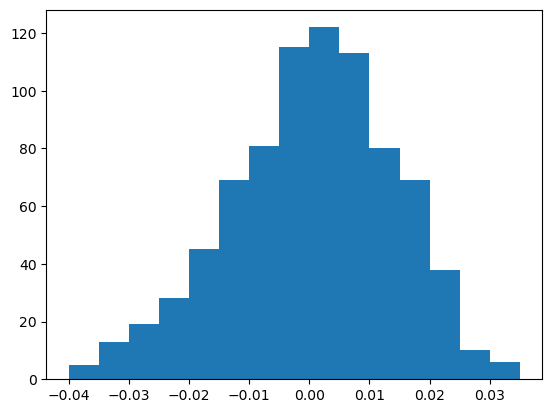

0.0006512542309514675
0.0012641815508576404


In [52]:
plt.figure()
plt.hist(def_rewards, bins=np.arange(-.04, .04, .005))
plt.show()
print(np.mean(def_rewards))
print(np.median(def_rewards))